In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score,balanced_accuracy_score
from sklearn.decomposition import PCA

##### Load the embeddings representations for the ACCP (which is the training dataset) and the HCP dataset (which will be the input for the trained SVM classifier)

In [20]:
embeddings_ACCP= pd.read_csv("/neurospin/dico/adufournet/Runs/01_Heritability_Right_PCS_HCP/Input/ACCpatterns_cingulate_full_embeddings.csv")#, index_col=0)
#embeddings_ACCP= pd.read_csv("/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Output/2024-05-17/17-33-50_137/ACCP_epoch60_embeddings/full_embeddings.csv")
embeddings_ACCP.head()
embeddings_ACCP.shape

(341, 257)

In [21]:
labels_ACCP = pd.read_csv("/neurospin/dico/data/deep_folding/current/datasets/ACCpatterns/subjects_labels.csv")
labels_ACCP = labels_ACCP[['long_name','Right_PCS']]
#labels_ACCP = labels_ACCP[['long_name','Left_PCS']]

In [22]:
def encoder(df, col):
    code = {'present':1,
            'absent':0}
    df[col] = df[col].map(code)
    return df

encoder(labels_ACCP,'Right_PCS') 
#encoder(labels_ACCP,'Left_PCS') 

,long_name,Right_PCS
0,nih_chp_04701_t1,0
1,nih_chp_01534_t1,1
2,nih_chp_04623_t1,1
3,nih_chp_01503_t1,0
4,nih_chp_00404_t1,1
...,...,...
376,a0005_t1_s03,1
377,a0006_t1_s03,0
378,a0001_t1_s03,1
379,a0016_t1_s03,1


In [23]:
embeddings_HCP = pd.read_csv("/neurospin/dico/adufournet/Runs/01_Heritability_Right_PCS_HCP/Input/hcp_cingulate_full_embeddings.csv", index_col=0)
#embeddings_HCP = pd.read_csv("/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Output/2024-05-17/17-33-50_137/HCP_epoch60_embeddings/full_embeddings.csv", index_col=0)
embeddings_HCP.head()

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
ID,,,,,,,,,,,,,,,,,,,,,
100206,-16.269560,-26.450573,6.987823,13.866329,-23.358473,11.751495,15.482762,-28.254500,2.468554,29.265993,...,0.255839,-26.942001,9.252998,9.163906,6.532629,10.676800,-14.139249,0.045611,-35.327550,-13.927697
100307,0.811358,-18.127650,-4.755681,22.113867,-5.715726,15.947124,9.402464,-19.022861,-13.003400,13.321704,...,6.490175,-8.862627,13.441197,2.842024,6.585532,25.127434,-6.861317,15.825949,-23.992393,-9.157214
100408,20.104237,19.609802,-11.392226,-22.513320,1.335086,-0.447604,-11.521453,-30.562178,-12.678901,13.097897,...,28.514357,-9.187751,-13.514122,-2.253131,2.700759,7.052255,-21.251228,-8.701427,-5.803285,-24.713255
100610,2.555209,-15.088083,36.982754,-11.100479,-20.611986,-8.845087,-1.762242,-5.469845,-0.281939,12.722241,...,-14.625642,-21.709137,7.999446,23.296196,2.751116,-6.180230,-41.432198,0.679659,-29.611362,-17.983616
101006,1.584482,-14.349580,0.897325,6.069071,-2.019094,34.008507,-11.613828,-19.883879,11.140767,4.942825,...,-17.744781,12.339481,5.968554,16.571490,7.573746,-6.312110,-21.530790,18.567806,-16.335620,3.381026


#### Load the UKBiobank embedded space to fit the scaler for the ACCP and HCP data 

In [24]:
embeddings_UKB = pd.read_csv("/neurospin/dico/adufournet/Runs/01_Heritability_Right_PCS_HCP/Program/2024-04-24/10-50-27_36/UKB_epoch60_embeddings/full_embeddings.csv", index_col=0)
#embeddings_UKB = pd.read_csv("/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Output/2024-05-17/17-33-50_137/UKB_epoch60_embeddings/full_embeddings.csv", index_col=0)
embeddings_UKB.head()

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
ID,,,,,,,,,,,,,,,,,,,,,
sub-1000021,-13.931313,-20.228790,-2.351910,22.903593,4.705052,18.064594,-0.727025,-17.399858,-6.217485,22.291307,...,-10.929922,1.404516,-4.437763,-17.509428,10.602697,-14.881742,-0.646338,14.122347,0.847274,23.677437
sub-1000458,-27.508526,-22.464178,15.330263,-8.684494,1.744135,16.401610,7.456940,-21.850723,19.866627,8.797631,...,-7.573163,0.289662,16.776058,14.058151,7.748422,-18.693428,-30.020218,30.022623,-14.871938,5.965506
sub-1000575,-9.019172,5.081558,13.194763,-9.988724,-4.874171,-24.418629,6.633943,-24.712519,-5.238509,-1.482300,...,5.858938,-25.280958,7.412261,12.342629,10.415935,4.523824,-7.905085,6.157226,-18.156778,-15.436461
sub-1000606,-5.862392,-8.704276,-22.276031,20.907238,0.767730,14.855814,-11.449471,-9.651089,-9.755624,32.766630,...,-20.278133,-2.978090,-14.676039,-8.346285,10.906873,21.820381,10.595843,5.306481,-19.714754,6.550507
sub-1000963,-25.473278,1.651641,-7.365778,-21.681479,18.501171,23.575530,-8.017796,-15.201870,5.839160,5.662610,...,-14.506186,10.651568,3.129409,-17.768148,-1.724178,-12.495091,2.465088,26.583134,12.387905,40.281150


#### Target

In [26]:
ebdd_lbl_ACCP = embeddings_ACCP.set_index('ID').join(labels_ACCP.set_index('long_name'))
X = ebdd_lbl_ACCP.drop('Right_PCS', axis=1) #Right_PCS, Left_PCS
y = ebdd_lbl_ACCP['Right_PCS'] #Right_PCS, Left_PCS

#### Scaler

In [27]:
scaler = StandardScaler()
scaler.fit(embeddings_UKB)
X = scaler.transform(X)
scl_bdd_hcp = scaler.transform(embeddings_HCP)
scl_bdd_ukb = scaler.transform(embeddings_UKB)
X.shape ,scl_bdd_hcp.shape

((341, 256), (1114, 256))

#### Principal component Analysis (PCA)

In [28]:
n_components=20

pca = PCA(n_components=n_components)
pca.fit(scl_bdd_hcp)
print(pca.explained_variance_ratio_)

[0.10527094 0.09111137 0.08223988 0.07012926 0.06590802 0.06246953
 0.06078963 0.0523035  0.05084819 0.0497824  0.04574203 0.04120748
 0.03886035 0.036928   0.03437501 0.02992803 0.02090255 0.01558867
 0.01137289 0.00868613]


In [29]:
(np.cumsum(pca.explained_variance_ratio_) < 0.99).sum()

20

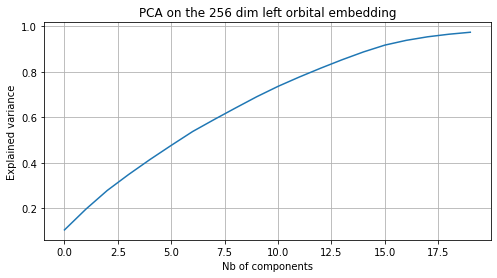

In [30]:
plt.figure(figsize=(8,4))
plt.plot(range(0,n_components,1), np.cumsum(pca.explained_variance_ratio_))
plt.grid(visible=True)
plt.xlabel('Nb of components')
plt.ylabel('Explained variance')
plt.title('PCA on the 256 dim left orbital embedding')
plt.show()

<AxesSubplot:>

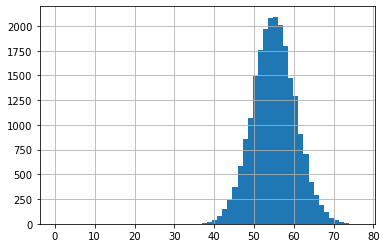

In [31]:
PCA_HCP = pca.transform(scl_bdd_hcp)
PCA_UKB = pca.transform(scl_bdd_ukb)

PCA_HCP = pd.DataFrame(PCA_HCP, columns=[f'Component_{i}' for i in range(n_components)])
PCA_UKB = pd.DataFrame(PCA_UKB, columns=[f'Component_{i}' for i in range(n_components)])

PCA_HCP['Dataset'] = 'hcp'
PCA_UKB['Dataset'] = 'UkBioBank'

PCA_HCP['ID'] = embeddings_HCP.index
PCA_UKB['ID'] = embeddings_UKB.index

PCA_All = pd.concat([PCA_UKB,PCA_HCP], axis=0)

# Calculate the centroid
centroid_values = PCA_All[[f'Component_{i}' for i in range(n_components)]].mean()

# Convert the centroid to a DataFrame
centroid = pd.DataFrame([centroid_values])
centroid['Dataset'] = 'centroid'
centroid['ID'] = 'centroid'

# Append the centroid row to the dataframe
PCA_All = pd.concat([PCA_All, centroid], axis=0, ignore_index=True)

# Function to calculate Manhattan distance to centroid
def calculate_manhattan_distance(row, centroid):
    return sum(abs(row[f'Component_{i}'] - centroid[f'Component_{i}']) for i in range(n_components))

# Calculate Manhattan distance for each point and add as a new column
PCA_All['Manhattan_Dist_to_Centroid'] = PCA_All.apply(
    lambda row: calculate_manhattan_distance(row, centroid_values) if row['ID'] != 'centroid' else 0,
    axis=1
)

PCA_All["Manhattan_Dist_to_Centroid"].hist(bins=60)

          IID  Manhattan_Dist_to_Centroid
21052  100206                   58.153030
21053  100307                   52.253816
21054  100408                   56.510113
21055  100610                   62.360216
21056  101006                   48.878870


array([[<AxesSubplot:title={'center':'Manhattan_Dist_to_Centroid'}>]],
      dtype=object)

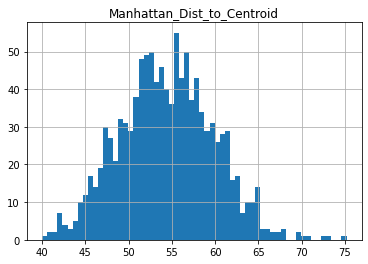

In [32]:
centroid_dist_hcp = PCA_All[PCA_All["Dataset"]=="hcp"][["ID","Manhattan_Dist_to_Centroid"]]
centroid_dist_hcp = centroid_dist_hcp.rename(columns={'ID': 'IID'})
print(centroid_dist_hcp.head())
centroid_dist_hcp.hist(bins=60)

**How does the AUC change using the principal components?**

In [33]:
X_pca = pca.transform(X=scl_bdd_hcp)
X_train_pca = pca.transform(X=X)

model = SVC(kernel='linear', probability=True,
            random_state=42,
            C=0.01, class_weight='balanced', decision_function_shape='ovr')

outputs = {}
val_pred = cross_val_predict(model, X_train_pca, y, cv=5)
auc = roc_auc_score(y, val_pred)
outputs['labels_pred'] = val_pred
outputs['auc'] = auc
outputs['balanced_accuracy_score'] = balanced_accuracy_score(y, val_pred)

print(f'auc_cv: {outputs["auc"]}')
print(f'balanced_accuracy_score_cv: {outputs["balanced_accuracy_score"]}')

model.fit(X_train_pca,y)

roc_auc_score(y,model.predict_proba(X_train_pca)[:,1]), balanced_accuracy_score(y, model.predict(X_train_pca))

auc_cv: 0.7630604906937394
balanced_accuracy_score_cv: 0.7630604906937394


(0.8993936830231246, 0.8152848279751833)

**For what heritability results?**

In [35]:
df_HCP_PC = pd.DataFrame({f'PC{i}' : X_pca[:,i-1] for i in range(1, n_components+1)})
df_HCP_PC["IID"] = list(embeddings_HCP.index)
df_HCP_PC.to_csv('/neurospin/dico/adufournet/Runs/01_Heritability_Right_PCS_HCP/Heritability/data/HCP_PCS_right.csv', index=False)
#df_HCP_PC.to_csv('/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Heritability/data/HCP_PCS.csv', index=False)
df_HCP_PC

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,IID
0,1.443215,-5.118218,-4.960553,0.853249,0.310682,-2.491746,1.282792,9.829260,-3.369191,0.786916,...,5.195928,1.164844,3.344873,-2.536333,-2.526931,-0.986997,3.218461,-1.444244,-0.123219,100206
1,-5.193344,-2.743193,-3.218170,-8.420746,-2.176710,4.160891,0.834254,2.672241,-6.485845,0.918917,...,-0.873327,1.662513,0.155564,-3.621489,-0.135779,-3.143152,0.097218,-0.637184,-1.680508,100307
2,-6.369126,4.474306,-1.517073,-2.786713,5.726195,-0.113179,-1.685885,2.994217,6.381800,-0.678575,...,4.809325,3.983135,-0.007599,3.102308,-0.161184,2.193653,-2.851559,-0.895269,2.411399,100408
3,-4.374439,-2.983876,1.867745,10.361493,-1.260279,3.588116,0.019590,1.898053,-6.760062,-3.545682,...,5.095979,-1.237020,-1.237676,3.440665,-3.336752,-2.575090,-2.979546,-0.974713,-1.711657,100610
4,-1.907473,-2.714219,-6.814126,2.314770,-4.924932,1.179593,-3.775178,-4.090835,0.034661,-3.406841,...,-3.868710,-1.522343,-1.112509,-0.595418,-3.133146,0.937701,3.238369,1.711200,0.755572,101006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1109,-7.171964,0.718895,4.849212,-4.740083,-5.716170,-2.541710,-4.777754,-2.164813,2.220754,3.448430,...,-0.129275,4.313423,7.513660,-3.314620,0.011159,2.168405,0.338210,4.834446,-0.588806,992774
1110,-4.068184,2.416262,1.441545,8.349828,-0.706998,1.497447,2.320403,-3.416671,-5.342331,3.851556,...,1.166381,-3.772290,-3.860570,-1.444531,-0.273002,-2.051581,-1.941833,0.710846,0.309859,993675
1111,-5.819370,-5.024866,-5.752778,3.101573,1.758022,2.960139,-0.864741,1.703861,-0.284801,0.812021,...,-2.169093,-0.397269,-2.782211,-1.058318,-3.365067,-0.126065,-0.112330,-1.335225,-1.760103,994273
1112,-0.407275,-5.871863,3.344067,-2.044060,6.736989,4.987821,4.865761,-0.994468,-5.273959,-3.300770,...,-0.957429,2.009218,-2.351969,0.383664,1.054854,0.909509,-2.448928,-3.094206,-0.045136,995174
